<a href="https://colab.research.google.com/github/raffaelenoro/tutorials/blob/raffaelenoro-dev/benchmark/lenet_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%matplotlib inline


# Benchmarking of LeNet model using MNIST, CIFAR-10 and ImageNet


We process the model and datasets as follows:
- Set up a NN Model for LeNet
- Show summary
- Download train/test data from 3 datasets
- Select a Loss function and Optimizer
- Train
- Test
- Show accuracy




## LeNet-5

It consists of:

> input (#channels, WxH) ->
>
> conv (3 to 6 ch, 5x5 kernel) -> relu -> maxpool2d (2x2) ->
>
> conv (6 to 16 ch, 5x5 kernel) -> relu -> maxpool2d (2x2) ->
>
> linear (400 to 120) -> relu
>
> linear (120 to 84) -> relu
>
> linear (84 to 10)

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F

data_type = 'MNIST'

if 'MNIST' == data_type:
  # MNIST
  channels = 1
  subsamples = 4
else:
  # CIFAR-10
  channels = 3
  subsamples = 5

class LeNet(nn.Module):
  
  def __init__(self):
    super().__init__()
    self.features = nn.Sequential(
        nn.Conv2d(channels, 6, 5),
        nn.ReLU(),
        nn.MaxPool2d(2, 2),
        nn.Conv2d(6, 16, 5),
        nn.ReLU(),
        nn.MaxPool2d(2, 2)
    )
    self.classifier = nn.Sequential(
        nn.Linear(16 * subsamples * subsamples, 120),
        nn.ReLU(),
        nn.Linear(120, 84),
        nn.ReLU(),
        nn.Linear(84, 10)
    )

  def forward(self, x):
    x = self.features(x)
    x = torch.flatten(x, 1)
    x = self.classifier(x)
    return x
    
net = LeNet()

### Summary of Parameters

In [3]:
from torchsummary import summary

if 'MNIST' == data_type:
  # MNIST
  input_size = (1, 28, 28)
else:
  # CIFAR-10
  input_size = (3, 32, 32)

summary(net, input_size)

for p in net.parameters():
  print(p.size())

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 24, 24]             156
              ReLU-2            [-1, 6, 24, 24]               0
         MaxPool2d-3            [-1, 6, 12, 12]               0
            Conv2d-4             [-1, 16, 8, 8]           2,416
              ReLU-5             [-1, 16, 8, 8]               0
         MaxPool2d-6             [-1, 16, 4, 4]               0
            Linear-7                  [-1, 120]          30,840
              ReLU-8                  [-1, 120]               0
            Linear-9                   [-1, 84]          10,164
             ReLU-10                   [-1, 84]               0
           Linear-11                   [-1, 10]             850
Total params: 44,426
Trainable params: 44,426
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/ba

### Datasets
Transform images from range [0, 1] to range [-1, 1]

In [4]:
import torchvision
import torchvision.transforms as transforms


if 'MNIST' == data_type:
  # MNIST
  dataset = torchvision.datasets.MNIST
  mean = (0.5,)
  std = (0.5,)
  classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')
else:
  # CIFAR-10
  dataset = torchvision.datasets.CIFAR10
  mean = (0.5, 0.5, 0.5)
  std = (0.5, 0.5, 0.5)
  classes = ('plane', 'car', 'bird', 'cat',
             'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(mean, std)])

trainset = dataset(root='./data', train=True,
                   download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = dataset(root='./data', train=False,
                  download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

print(trainset)
print(testset)

  0%|          | 0/9912422 [00:00<?, ?it/s]

9920512it [00:00, 28428509.07it/s]                            


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz


32768it [00:00, 452012.61it/s]
  2%|▏         | 40960/1648877 [00:00<00:04, 398230.65it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz


1654784it [00:00, 8888991.97it/s]                          
8192it [00:00, 169849.67it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz
Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!
Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test


### Loss function and optimizer
Using the Cross Entropy loss with the Stochastic Gradient Descent optimizer (learn rate is 0.001, momentum is 0.9)

In [0]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

### Train the Network
Train over the dataset a few times

In [6]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 1.246
[1,  4000] loss: 0.204
[1,  6000] loss: 0.147
[1,  8000] loss: 0.115
[1, 10000] loss: 0.091
[1, 12000] loss: 0.089
[1, 14000] loss: 0.088
[2,  2000] loss: 0.063
[2,  4000] loss: 0.068
[2,  6000] loss: 0.063
[2,  8000] loss: 0.063
[2, 10000] loss: 0.069
[2, 12000] loss: 0.059
[2, 14000] loss: 0.059
Finished Training


### Test the network
Look first at one test sample.

GroundTruth:      7     2     1     0
Predicted:      7     2     1     0


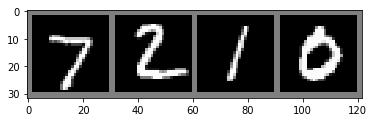

In [7]:
import numpy as np
import matplotlib.pyplot as plt

dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
grid = torchvision.utils.make_grid(images)
grid = grid / 2 + 0.5     # unnormalize
npgrid = grid.numpy()
plt.imshow(np.transpose(npgrid, (1, 2, 0)))

print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

outputs = net(images)

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Look at how the network performs on the whole dataset.

In [8]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 98 %
